# **Hyperparameters**

In [1]:
RANDOM_SEED = 42
TAREGT_SIZE_TUPLE = (512, 512)
DATASET_FRAC_TO_USE = 1 #(1 = 100% of the dataset)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1
CLUSTEING_CENTROIDS_DIFFERENCE_TOLERANCE = 1e-4
DENSE_LAYER_UNITS = 128
LEARNING_RATE = 0.001
IMAGE_DATA_GENERATOR_RORATION_ANGLE = 20
BATCH_SIZE = 16
EPOCHS = 10
CORSS_VALIDATIOLN_ITERATIONS = 4

# **Functions used**


In [2]:
# kagglehub.dataset_download()
# os.path.join()
# os.walk()
# os.listdir()
# random.seed()
# random.sample()
# Image.open() (from PIL)
# imagehash.phash() (from imagehash)
# np.random.seed() (from numpy)
# np.array() (from numpy)
# np.stack() (from numpy)
# np.random.normal() (from numpy)
# np.zeros() (from numpy)
# np.max() (from numpy)
# np.mean() (from numpy)
# np.maximum() (from numpy)
# np.linalg.norm() (from numpy.linalg)
# np.argmin() (from numpy)
# np.unique() (from numpy)
# np.random.choice() (from numpy)
# np.all() (from numpy)
# np.argmax() (from numpy)
# pd.DataFrame() (from pandas)
# pd.Series() (from pandas)
# train_test_split() (from scikit-learn)
# models.Sequential() (from tensorflow.keras.models)
# layers.Conv2D() (from tensorflow.keras.layers)
# layers.MaxPooling2D() (from tensorflow.keras.layers)
# layers.Flatten() (from tensorflow.keras.layers)
# layers.Dense() (from tensorflow.keras.layers)
# tf.random.set_seed() (from tensorflow)
# tf.keras.optimizers.Adam() (from tensorflow.keras.optimizers)
# ReduceLROnPlateau() (from tensorflow.keras.callbacks)
# EarlyStopping() (from tensorflow.keras.callbacks)
# ImageDataGenerator() (from tensorflow.keras.preprocessing.image)
# matplotlib.pyplot.subplot() (used as plt.subplot())
# matplotlib.pyplot.imshow() (used as plt.imshow())
# matplotlib.pyplot.title() (used as plt.title())
# matplotlib.pyplot.axis() (used as plt.axis())
# matplotlib.pyplot.show() (used as plt.show())
# matplotlib.pyplot.plot() (used as plt.plot())
# matplotlib.pyplot.xlabel() (used as plt.xlabel())
# matplotlib.pyplot.ylabel() (used as plt.ylabel())
# matplotlib.pyplot.tight_layout() (used as plt.tight_layout())
# time() (from time)
# KFold() (from scikit-learn)
# confusion_matrix() (from scikit-learn.metrics)
# ConfusionMatrixDisplay() (from scikit-learn.metrics)

# **Milestone 2**

### Packages installation

In [3]:
!pip install kagglehub
!pip install imagehash
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm
print("done installing packages")

done installing packages


### imports

In [4]:
import os
import kagglehub
import random
from PIL import Image
import imagehash
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm 
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.decomposition import PCA
from time import time

print("done importing packages")


2025-05-01 11:34:30.916652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746099271.108990      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746099271.165260      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done importing packages


## **Data preparaion**

### Dataset path

In [5]:
if 'COLAB_GPU' in os.environ:
    dataset_folder = kagglehub.dataset_download('hussainghoraba/emotions-dataset')
    DATASET_PATH = os.path.join(dataset_folder, 'Dataset')
elif 'KAGGLE_URL_BASE' in os.environ:
    DATASET_PATH = '/kaggle/input/emotions-dataset/Dataset'
elif 'VSCODE_PID' in os.environ:
    DATASET_PATH = './Dataset'
else:
    raise Exception('Unknown environment')

print("done setting up dataset path")

done setting up dataset path


### Set random seed for consistent outputs through multiple runs

In [6]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
print("done setting up random seed")

done setting up random seed


### Helper functions

In [7]:
def calculate_and_print_time(start_time, section_name):
    end_time = time()
    time_taken = end_time - start_time
    hours = int(time_taken // 3600)
    minutes = int((time_taken % 3600) // 60)
    seconds = int((time_taken % 3600) % 60)
    print(f'\n{section_name} Done in : {hours} h, {minutes} m, {seconds} s')
    
def extend_depth(filters, depth):
    return np.stack([filters] * depth, axis=-1)

def get_image_flattened_windows(input_data, filter_size):
    input_h, input_w, input_c = input_data.shape
    output_h = input_h - filter_size + 1
    output_w = input_w - filter_size + 1

    col = np.zeros((output_h * output_w, filter_size * filter_size * input_c))
    i = 0
    for h in range(output_h):
        for w in range(output_w):
            cube = input_data[h:h+filter_size, w:w+filter_size, :]
            # flatten the window, for fast matrix multiplication in conv layer
            col[i, :] = cube.flatten()
            i += 1
    return col

def downsample_features(features_arrays):
    # downsample the features arrays to only 128 dimensions
    # use PCA only if we have more than 128 feature arrays ,
    # this is because in PCA, the number of components (which is 128 in our case) 
    # must be less than the number of samples.
    # if we have less than 128 feature arrays, we will just select random 128 features
    if features_arrays.shape[0] >= 128:
        print(f"appling PCA for features downsampling...")
        features_arrays = PCA(n_components=128).fit_transform(features_arrays)
    else:
        print(f"selecting random 128 features from {features_arrays.shape[1]} features...")
        selected_indices = np.random.choice(features_arrays.shape[1], 128, replace=False)
        features_arrays = features_arrays[:, selected_indices]
    return features_arrays

def extract_features(model, df):
    start_time = time()
    num_features = model.layers[-1].output_shape[0]
    features_arrays = np.zeros((len(df), num_features))

    with tqdm(total=len(df), desc="Extracting features...") as pbar:
        for i in range(len(df)):
            img_arr = df.iloc[i]['img_arr']
            features_arrays[i, :] = model.forward(img_arr)
            pbar.update(1)
    calculate_and_print_time(start_time, "Feature Extraction without downsampling")
    return downsample_features(features_arrays)

def calculate_accuracy(true_labels, predicted_labels):
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    correct_predictions = np.sum(true_labels == predicted_labels)
    accuracy = correct_predictions / len(true_labels)
    return accuracy

def get_hardware_name():
    if tf.config.list_physical_devices('GPU'):
        return 'GPU'
    return 'CPU'

### Load dataset into memory without dups, and with correct size, and equalize the number of images in each class


In [8]:
global_start_time = time()
total_images_count = sum(len(files) for _, _, files in os.walk(DATASET_PATH))
print(f"Total images in dataset: {total_images_count}")
train_features_arrays = []
dups_pairs = set()
  
num_images_in_smallest_category = min(len(os.listdir(os.path.join(DATASET_PATH, folder))) for folder in os.listdir(DATASET_PATH))
num_of_images_to_use_in_each_category = int(num_images_in_smallest_category * DATASET_FRAC_TO_USE)
num_of_categories = len(os.listdir(DATASET_PATH))
total_images_to_load = int(num_images_in_smallest_category * num_of_categories * DATASET_FRAC_TO_USE)

with tqdm(total=total_images_to_load, desc="Loading images into memory...") as pbar:
    for subfolder in os.listdir(DATASET_PATH):
        subfolder_path = os.path.join(DATASET_PATH, subfolder)
        subfolder_hashes = {}

        all_category_images = os.listdir(subfolder_path)
        # we must use the same number of images from each category to avoid bias
        images_to_load = random.sample(all_category_images, num_of_images_to_use_in_each_category)
        
        for img_file in images_to_load:
            img_path = os.path.join(subfolder_path, img_file)
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize(TAREGT_SIZE_TUPLE)
                img_arr = np.array(img)
                img_hash = imagehash.phash(img)
            if img_hash not in subfolder_hashes.keys():
                train_features_arrays.append({"img_path": img_path, "label": subfolder, "img_arr": img_arr})
                # key : hash, value : img_path
                subfolder_hashes[img_hash] = img_path
            else:
                existing_duplicate = subfolder_hashes[img_hash]
                dups_pairs.add((img_path, existing_duplicate))
            pbar.update(1)
        
df = pd.DataFrame(train_features_arrays)

# display removed dups
for dup_pair in dups_pairs:
    print(f"Duplicate images found: {dup_pair[0]} and {dup_pair[1]}")
    img1 = Image.open(dup_pair[0])
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(os.path.basename(dup_pair[0]))
    plt.axis('off')
    img2 = Image.open(dup_pair[1])
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(os.path.basename(dup_pair[1]))
    plt.axis('off')
    plt.show()
calculate_and_print_time(global_start_time, "Loading images into memory")

Total images in dataset: 2125


Loading images into memory...: 100%|██████████| 1188/1188 [00:27<00:00, 43.26it/s]


Loading images into memory Done in : 0 h, 0 m, 36 s


### Train/Test/Val split

In [9]:
train_df, temp_df = train_test_split(df, test_size=(1 - TRAIN_RATIO), stratify=df['label'], random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=(TEST_RATIO / (TEST_RATIO + VAL_RATIO)), stratify=temp_df['label'], random_state=RANDOM_SEED)

# Print the sizes of each split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

print("\ntraining set:")
print(train_df['label'].value_counts())

print("\nvalidation set:")
print(val_df['label'].value_counts())

print("\ntest set:")
print(test_df['label'].value_counts())


print("done splitting dataset into train, val, test")

Training set size: 831
Validation set size: 238
Test set size: 119

training set:
label
Angry      208
Sad        208
Happy      208
Neutral    207
Name: count, dtype: int64

validation set:
label
Angry      60
Neutral    60
Happy      59
Sad        59
Name: count, dtype: int64

test set:
label
Sad        30
Neutral    30
Happy      30
Angry      29
Name: count, dtype: int64
done splitting dataset into train, val, test


## **Model 1**

### Classes & Functions

In [10]:
class ConvLayer:
    def __init__(self, filter_size=3, num_filters=5, filter_weights=None):
        self.filter_size = filter_size
        self.num_filters = num_filters
        if filter_weights is None:
            filter_weights = np.random.normal(size=(num_filters, filter_size, filter_size)) * 0.1
        self.filter_weights = filter_weights

        self.input_shape = None
        self.output_shape = None
        self.deep_filters = None
        self.deep_filters_shape = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        input_h, input_w, input_c = input_shape

        # ------------------- define the output shape 
        output_h = input_h - self.filter_size + 1
        output_w = input_w - self.filter_size + 1
        self.output_shape = (output_h, output_w, self.num_filters)

        # ------------------- initilize deep filters 
        #  extend the filter weights depth so that filter depth = input depth (input channels)
        self.deep_filters = extend_depth(self.filter_weights, input_c)
        self.deep_filters_shape = self.deep_filters.shape
        # flatten the filters for fast matrix multiplication in the "forward" fuction
        self.deep_filters = self.deep_filters.reshape(self.num_filters, -1)


    def forward(self, input_image):
        # the function uses matrix multiplication, so it is really fast
        output_h, output_w = self.output_shape[0], self.output_shape[1]
        input_col = get_image_flattened_windows(input_image, self.filter_size)
        output_flat = self.deep_filters @ input_col.T
        output = output_flat.T.reshape(output_h, output_w, self.num_filters)
        return output
    

class PoolingLayer:
    def __init__(self, pool_size=2, pool_type='MAX'):
        if pool_type not in ['MAX', 'AVERAGE']:
            raise ValueError("pool_type must be either 'MAX' or 'AVERAGE'")
        self.pool_size = pool_size
        self.pool_type = pool_type

        self.input_shape = None
        self.output_shape = None
        self.output = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        input_h, input_w, input_c = input_shape

        # define the output shape
        output_h = input_h // self.pool_size
        output_w = input_w // self.pool_size
        self.output_shape = (output_h, output_w, input_c)

        # initialize the output array
        self.output = np.zeros(self.output_shape)

    def forward(self, input_image):
        for i in range(self.output.shape[0]):
            for j in range(self.output.shape[1]):
                h_start = i * self.pool_size
                h_end = h_start + self.pool_size
                w_start = j * self.pool_size
                w_end = w_start + self.pool_size

                pool_window = input_image[h_start:h_end, w_start:w_end, :]

                if self.pool_type == 'MAX':
                    self.output[i, j, :] = np.max(pool_window, axis=(0, 1))
                elif self.pool_type == 'AVERAGE':
                    self.output[i, j, :] = np.mean(pool_window, axis=(0, 1))

        # apply relu
        return np.maximum(0, self.output)
    
class FlatteningLayer:
    def __init__(self):
        self.input_shape = None
        self.output_shape = None

    def set_input_shape(self, input_shape):
        self.input_shape = input_shape
        self.output_shape = (input_shape[0] * input_shape[1] * input_shape[2],)

    def forward(self, input_image):
        return input_image.flatten()


class Model_1:
    def __init__(self, layers, first_layer_input_shape):
        self.layers = layers

        # Set the input shape for each layer based on the output shape of the previous layer
        previous_layer_shape = first_layer_input_shape
        for layer in self.layers:
            layer.set_input_shape(previous_layer_shape)
            previous_layer_shape = layer.output_shape  

    def visualize_architecture(self):
        print("Model 1 architecture : 🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️\n")
        for i, layer in enumerate(self.layers):
            print(f"Layer {i + 1}: {layer.__class__.__name__}")
            print(f"Input shape: {layer.input_shape}")
            print(f"Output shape: {layer.output_shape}")
            if isinstance(layer, ConvLayer):
                print(f"Number of filters: {layer.deep_filters_shape[0]}")
                print(f"Filter Shape: {layer.deep_filters_shape[-3:]}")
            elif isinstance(layer, PoolingLayer):
                print(f"Pooling size: {layer.pool_size}")
                print(f"Pooling type: {layer.pool_type}")
            print("-" * 30)

    def forward(self, input_image):
        output = input_image
        for layer in self.layers:
            output = layer.forward(output)
        return output

class Custom_Kmeans:
    def __init__(self, k):
        self.k = k
        self.centroids = None
        self.clusters_names = None
        self.index_labels = None

    def predict(self, feature_arr):
        distances = np.linalg.norm(feature_arr - self.centroids, axis=1)
        cluster_index = np.argmin(distances)

        # replace every index label with the name of the centroid, put in a new array
        # exmaple : convert [0, 1, 2, 3] to ['happy', 'sad', 'angry', 'neutral']
        return self.clusters_names[cluster_index]
    
    def get_clusters_names(self, true_labels):
        # name each cluster as the name of the most frequent label in the cluster
        # if a cluster name is already used, we will use the next most frequent label in the cluster
        num_of_classes = len(np.unique(true_labels))
        used_names = set()
        cluster_names = [None] * num_of_classes
        for i in range(num_of_classes):
            cluster_labels = true_labels[self.index_labels == i] # ['happy', 'sad', 'happy', ...]
            label_counts = pd.Series(cluster_labels).value_counts()
            sorted_label_counts = label_counts.sort_values(ascending=False)
            # git the most frequent non-used label in the cluster
            for label, _ in sorted_label_counts.items():
                if label not in used_names:
                    cluster_names[i] = label
                    used_names.add(label)
                    break
        return np.array(cluster_names)
    
    def fit(self, train_features_arrays, train_features_arrays_labels, val_features_arrays, val_features_arrays_labels):
        # train_features_arrays & val_features_arrays are 2D arrays of shape (num_images, num_features)
        # features_arrays_labels & val_features_arrays_labels are  1D arrays of shape (num_samples,), 
        # representing the labels of images whose features are passed as features_arrays
        rows_count = train_features_arrays.shape[0]

        # Initialize centroids randomly    gg
        self.centroids = train_features_arrays[np.random.choice(rows_count, self.k, replace=False)]

        iterations_accuracies = []
        while True:
            distances = np.linalg.norm(train_features_arrays[:, np.newaxis] - self.centroids, axis=2)
            self.index_labels = np.argmin(distances, axis=1) 
            previous_centroids = self.centroids.copy()
            self.centroids = np.array([train_features_arrays[self.index_labels == i].mean(axis=0) for i in range(self.k)])
            
            # name each cluster as the name of the most frequent label in the cluster
            self.clusters_names = self.get_clusters_names(train_features_arrays_labels)

            # predict the labels of the validation set
            val_predicted_labels = np.array([self.predict(val_features_arrays[i]) for i in range(len(val_features_arrays))])

            # calculate the accuracy of the validation set
            val_accuracy = calculate_accuracy(val_features_arrays_labels, val_predicted_labels)
            iterations_accuracies.append(val_accuracy)

            # breack if difference between new and old centroids is small
            if np.all(np.linalg.norm(self.centroids - previous_centroids, axis=1) < CLUSTEING_CENTROIDS_DIFFERENCE_TOLERANCE):
                break
        return iterations_accuracies


### Building model 1

In [11]:
filter_weights = np.stack([
    np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]),
    np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]),
    np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]),
    np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
], axis=0)

model_1 = Model_1(
    layers=[
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        ConvLayer(filter_size=3, num_filters=5, filter_weights=filter_weights),
        PoolingLayer(pool_size=2, pool_type='MAX'),
        FlatteningLayer()
    ],
    first_layer_input_shape=df.iloc[0]['img_arr'].shape
)

### Visualize model 1 architecture

In [12]:
model_1.visualize_architecture()

Model 1 architecture : 🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️

Layer 1: ConvLayer
Input shape: (512, 512, 3)
Output shape: (510, 510, 5)
Number of filters: 5
Filter Shape: (3, 3, 3)
------------------------------
Layer 2: PoolingLayer
Input shape: (510, 510, 5)
Output shape: (255, 255, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 3: ConvLayer
Input shape: (255, 255, 5)
Output shape: (253, 253, 5)
Number of filters: 5
Filter Shape: (3, 3, 5)
------------------------------
Layer 4: PoolingLayer
Input shape: (253, 253, 5)
Output shape: (126, 126, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 5: ConvLayer
Input shape: (126, 126, 5)
Output shape: (124, 124, 5)
Number of filters: 5
Filter Shape: (3, 3, 5)
------------------------------
Layer 6: PoolingLayer
Input shape: (124, 124, 5)
Output shape: (62, 62, 5)
Pooling size: 2
Pooling type: MAX
------------------------------
Layer 7: FlatteningLayer
Input shape: (62, 62, 5)
Output shape: (

### Using model 1 to extract features from both train and test datasets

In [13]:
train_features_arrays = extract_features(model_1, train_df)
val_features_arrays = extract_features(model_1, val_df)

Extracting features...: 100%|██████████| 831/831 [14:00<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 14 m, 0 s
appling PCA for features downsampling...


Extracting features...: 100%|██████████| 238/238 [04:01<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 4 m, 1 s
appling PCA for features downsampling...


### Clustering 
cluster model_1 extracted features using custom k-means clustering algorithm

In [14]:
num_classes = len(df['label'].unique())
train_features_arrays_labels = train_df['label'].values
val_features_arrays_labels = val_df['label'].values

kmeans = Custom_Kmeans(k=num_classes)
clustering_val_accuracies_histroy = kmeans.fit(train_features_arrays, train_features_arrays_labels, val_features_arrays, val_features_arrays_labels)
print(f"Model 1 val accuracy: {clustering_val_accuracies_histroy[-1]:.2f}")
print("Model 1 Iterations until k-means convergence: ", len(clustering_val_accuracies_histroy))
print()


# print the number of each class in each cluster
for i in range(num_classes):
    cluster_labels = train_features_arrays_labels[kmeans.index_labels == i]
    print(f"Cluster {i} : {kmeans.clusters_names[i]}")
    print(f"Cluster {i}:")
    print(pd.Series(cluster_labels).value_counts())
    print("-" * 30)

Model 1 val accuracy: 0.32
Model 1 Iterations until k-means convergence:  19

Cluster 0 : Happy
Cluster 0:
Happy      48
Angry      40
Neutral    33
Sad        19
Name: count, dtype: int64
------------------------------
Cluster 1 : Sad
Cluster 1:
Sad        76
Neutral    64
Angry      51
Happy      42
Name: count, dtype: int64
------------------------------
Cluster 2 : Angry
Cluster 2:
Sad        72
Angry      63
Happy      63
Neutral    58
Name: count, dtype: int64
------------------------------
Cluster 3 : Neutral
Cluster 3:
Happy      55
Angry      54
Neutral    52
Sad        41
Name: count, dtype: int64
------------------------------


### Testing model 1 on the test set

In [15]:
test_features_arrays = extract_features(model_1, test_df)
test_features_arrays_labels = test_df['label'].values
test_predicted_labels = np.array([kmeans.predict(test_features_arrays[i]) for i in range(len(test_features_arrays))])
test_accuracy = calculate_accuracy(test_features_arrays_labels, test_predicted_labels)
print(f"Model 1 test accuracy: {test_accuracy:.2f}")

Extracting features...: 100%|██████████| 119/119 [01:59<00:00,  1.00s/it]


Feature Extraction without downsampling Done in : 0 h, 1 m, 59 s
selecting random 128 features from 19220 features...
Model 1 test accuracy: 0.24


### Displyaing sample inputs and outputs for model 1 (for the report)

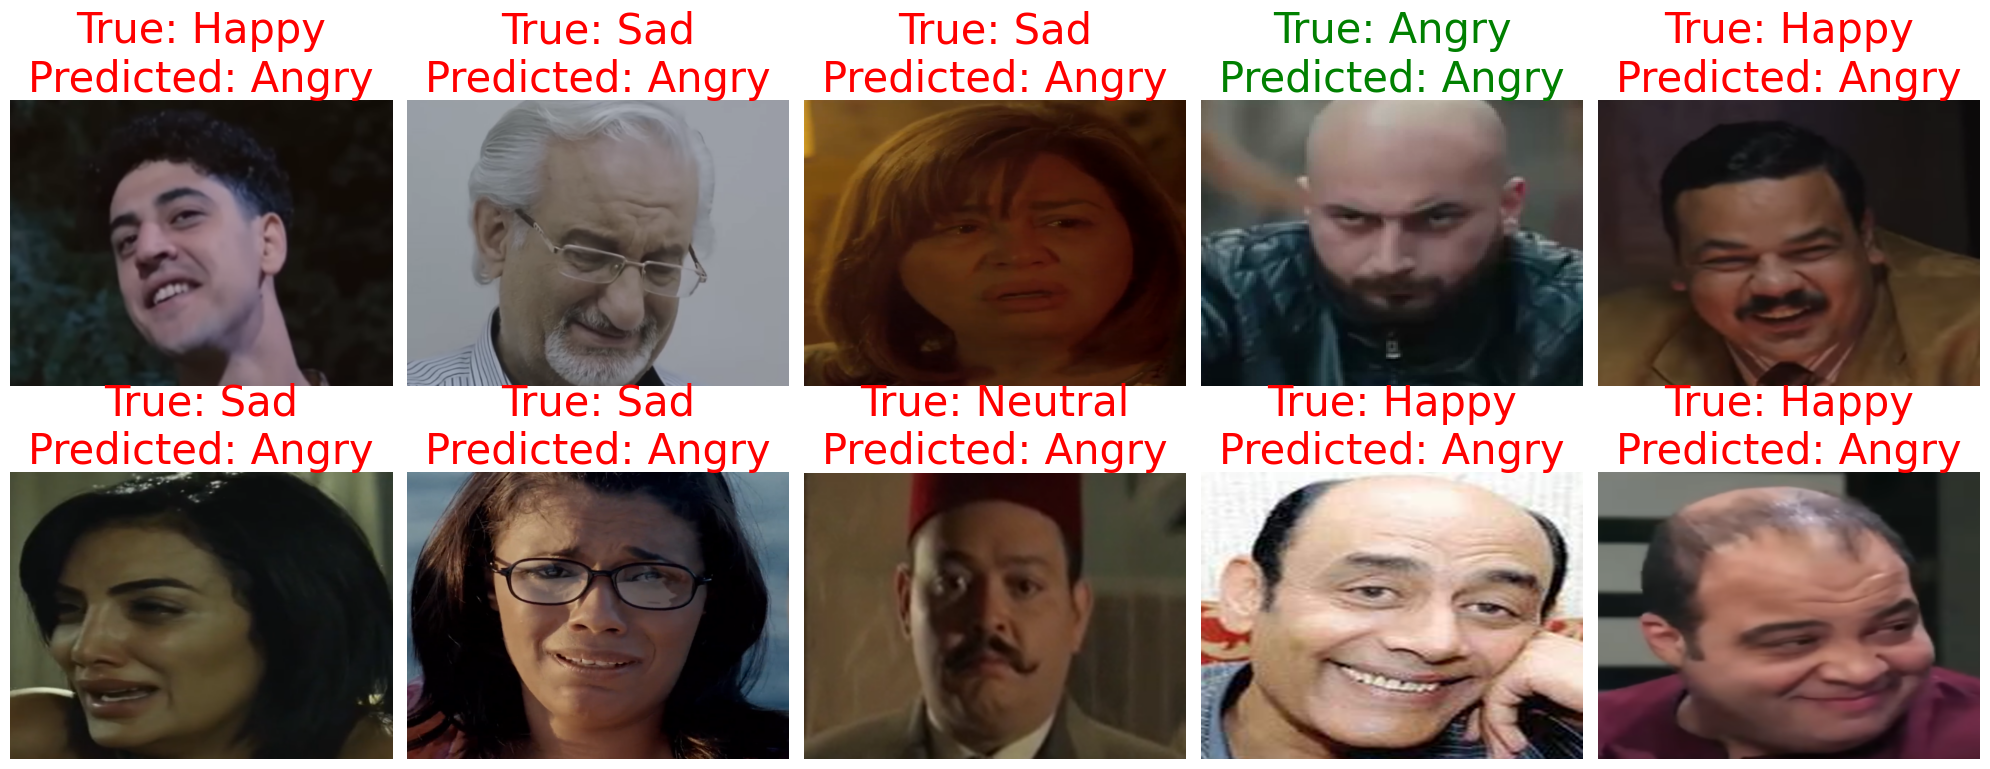

In [16]:
test_samples_count = min(10, len(test_df))
test_samples = test_df.sample(test_samples_count)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, (index, row) in enumerate(test_samples.iterrows()):
    img = Image.open(row['img_path'])
    true_label = row['label']
    predicted_label = test_predicted_labels[i]
    
    title_color = 'green' if true_label == predicted_label else 'red'
    
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].set_title(
        f"True: {true_label}\nPredicted: {predicted_label}",
        fontsize=30,  
        color=title_color  
    )
    axes[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()

## **Model 2**

### Build model 2

In [17]:
# TA : "You should have 5 convolution blocks each with 3 layers.
#  3 convolution layers are simply 3 different filters on the same stage.
#  A convolution block is some conv filters (layers) followed by an activation function and then a max pooling. 
# All convolution filters in the same block need to have the same size."

def create_model2():
    model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(TAREGT_SIZE_TUPLE[0], TAREGT_SIZE_TUPLE[1], 3)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(DENSE_LAYER_UNITS, activation='sigmoid'),
    layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model

model2 = create_model2()


print("done building model 2")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746100527.086795      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


done building model 2


### Visualize model 2 architecture

In [18]:
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 508, 508, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 506, 506, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 253, 253, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 251, 251, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 249, 249, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 247, 247, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 121, 121, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 119, 119, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 117, 117, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 54, 54, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 50, 50, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 46, 46, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 17, 17, 16)          │          25,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 11, 11, 16)          │          12,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 5, 5, 16)            │          12,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 384,084 (1.47 MB)

 Trainable params: 384,084 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

### Early stopping to prevent overfitting (for the BONUS)

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

### Data augmentation (for the BONUS)

In [20]:
# thiss will rotate the images by up to 20 degrees, also will increase the 
# dataset size on the fly while training 

# the rescaling is done to normalize the pixel values to be between 0 and 1, for more numerical stability while training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=IMAGE_DATA_GENERATOR_RORATION_ANGLE,
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

### Model 2 training

In [ ]:
start_time = time()

# print trining dataset size before and after augmentation, note that augmentation increases the training dataset size on the fly while training
print(f"Training dataset size before augmentation: {len(train_df)}")
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    target_size=TAREGT_SIZE_TUPLE,
    x_col='img_path',  
    y_col='label',    
    batch_size=BATCH_SIZE,
    class_mode='categorical', 
    shuffle=True
)
print(f"Training dataset size after augmentation: {train_gen.n}")

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    target_size=TAREGT_SIZE_TUPLE,
    x_col='img_path',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
print(f"images sizes passed to image data generator: {train_gen.image_shape}")


model2_history = model2.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=[early_stoping, learning_rate_reduction],
    epochs=EPOCHS,
)

print(f"Val accuracy: {model2_history.history['val_accuracy'][-1]:.2f}")
calculate_and_print_time(start_time, "Training model 2")


Training dataset size before augmentation: 831
Found 831 validated image filenames belonging to 4 classes.
Training dataset size after augmentation: 831
Found 238 validated image filenames belonging to 4 classes.
images sizes passed to image data generator: (512, 512, 3)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746100548.238934      98 service.cc:148] XLA service 0x7b09b020a620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746100548.239953      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746100548.920923      98 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-01 11:56:04.631569: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,510,510]{3,2,1,0}, f32[16,32,508,508]{3,2,1,0}), window={size=3x3}, d

 7/52 ━━━━━━━━━━━━━━━━━━━━ 36s 806ms/step - accuracy: 0.2739 - loss: 1.4358

2025-05-01 11:56:33.449346: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,32,510,510]{3,2,1,0}, f32[15,32,508,508]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-01 11:56:34.382510: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.933344745s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,32,510,510]{3,2,1,0}, f32[15,32,508,508]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","c

52/52 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.2565 - loss: 1.4013 - val_accuracy: 0.2521 - val_loss: 1.3929 - learning_rate: 0.0010
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 912ms/step - accuracy: 0.2434 - loss: 1.3912 - val_accuracy: 0.2479 - val_loss: 1.3994 - learning_rate: 0.0010
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 848ms/step - accuracy: 0.2060 - loss: 1.4061
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
52/52 ━━━━━━━━━━━━━━━━━━━━ 55s 923ms/step - accuracy: 0.2061 - loss: 1.4060 - val_accuracy: 0.2479 - val_loss: 1.3873 - learning_rate: 0.0010
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 55s 924ms/step - accuracy: 0.2184 - loss: 1.3908 - val_accuracy: 0.2479 - val_loss: 1.3876 - learning_rate: 5.0000e-04
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.2823 - loss: 1.3881
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
52/52 ━━━━━━━━━━━━━━━━━━━━ 54s 913ms/step - accuracy: 0.2818 - loss: 1.3881 - val_ac

### Testing model 2 on the test set

In [22]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    target_size=TAREGT_SIZE_TUPLE,
    x_col='img_path',
    y_col='label',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_loss, test_acc = model2.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.2f}")

Found 119 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 681ms/step - accuracy: 0.2308 - loss: 1.3864
Test accuracy: 0.25


### Disply sample inputs and outputs from for model 2 (for the report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


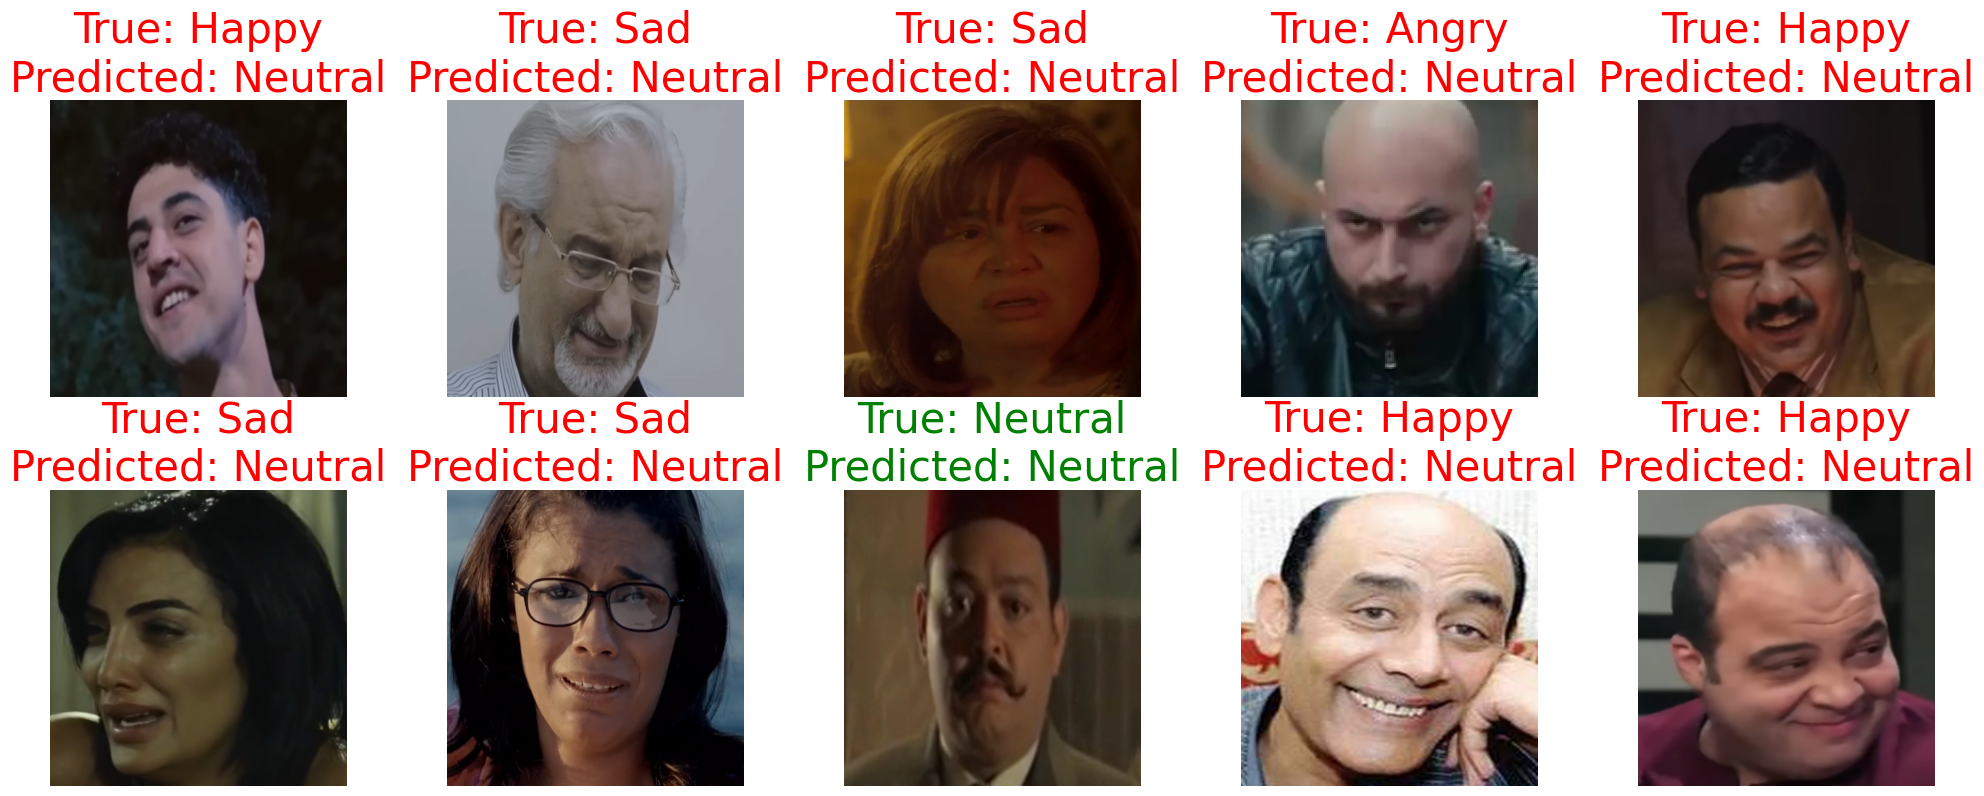

In [23]:
# Map class indices to class names
class_indices = train_gen.class_indices  
class_labels = {v: k for k, v in class_indices.items()} 

test_images = np.stack(test_samples['img_arr'].values)
# Normalize test images because the image was trained on normalized images
test_images = test_images / 255.0  

predicted_probs = model2.predict(test_images)
predicted_classes = np.argmax(predicted_probs, axis=1) 

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, (index, row) in enumerate(test_samples.iterrows()):
    img = row['img_arr']
    true_label = row['label']
    predicted_label = class_labels[predicted_classes[i]]
    
    title_color = 'green' if true_label == predicted_label else 'red'
    
    axes[i].imshow(img)
    axes[i].set_title(
        f"True: {true_label}\nPredicted: {predicted_label}",
        fontsize=30, 
        color=title_color
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### print Milestone 2 run time

In [24]:
calculate_and_print_time(global_start_time, f"Milestone 2 on {get_hardware_name()}")


Milestone 2 on GPU Done in : 0 h, 31 m, 16 s


# **Milestone 3**

## **model 1**


### Accuracy vs iterations (model 1)


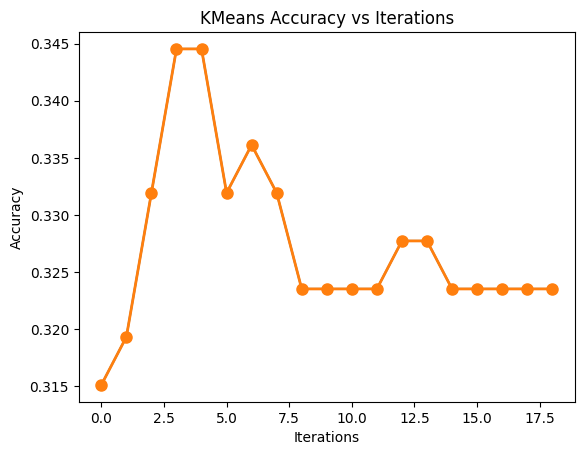

In [25]:
plt.plot(clustering_val_accuracies_histroy)
plt.plot(clustering_val_accuracies_histroy, marker='o', markersize=8, linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('KMeans Accuracy vs Iterations')
plt.show()

### K-fold cross-validation (model 1)

In [26]:
kf = KFold(n_splits=CORSS_VALIDATIOLN_ITERATIONS, shuffle=True, random_state=RANDOM_SEED)
fold_accuracies = []
start_time = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\nStarting fold {fold + 1}/{CORSS_VALIDATIOLN_ITERATIONS}...")
    
    fold_train_rows = df.iloc[train_idx]
    fold_train_features = extract_features(model_1, fold_train_rows)
    fold_train_labels = fold_train_rows['label'].values

    fold_val_rows = df.iloc[val_idx]
    fold_val_features = extract_features(model_1, fold_val_rows)
    fold_val_labels = fold_val_rows['label'].values
    
    fold_custom_kmeans = Custom_Kmeans(k=num_classes)

    # the .fit function returns the accuracies while training k-means, we only want the 
    # accuracy after the k-means converges, which is the last one in the list
    fold_val_accuracy = fold_custom_kmeans.fit(fold_train_features, fold_train_labels, fold_val_features, fold_val_labels)[-1]

    fold_accuracies.append(fold_val_accuracy)

formatted_accuracies = [f"{acc:.2f}" for acc in fold_accuracies]
print(f"\n Validation accuracies for each fold: {formatted_accuracies}, mean: {np.mean(fold_accuracies):.2f}")
calculate_and_print_time(start_time, "Cross validation for model 1")


Starting fold 1/4...


Extracting features...: 100%|██████████| 891/891 [15:00<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 15 m, 0 s
appling PCA for features downsampling...


Extracting features...: 100%|██████████| 297/297 [05:00<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 5 m, 0 s
appling PCA for features downsampling...

Starting fold 2/4...


Extracting features...: 100%|██████████| 891/891 [14:57<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 14 m, 57 s
appling PCA for features downsampling...


Extracting features...: 100%|██████████| 297/297 [04:56<00:00,  1.00it/s]



Feature Extraction without downsampling Done in : 0 h, 4 m, 56 s
appling PCA for features downsampling...

Starting fold 3/4...


Extracting features...: 100%|██████████| 891/891 [14:59<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 14 m, 59 s
appling PCA for features downsampling...


Extracting features...: 100%|██████████| 297/297 [05:00<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 5 m, 0 s
appling PCA for features downsampling...

Starting fold 4/4...


Extracting features...: 100%|██████████| 891/891 [15:00<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 15 m, 0 s
appling PCA for features downsampling...


Extracting features...: 100%|██████████| 297/297 [04:58<00:00,  1.01s/it]



Feature Extraction without downsampling Done in : 0 h, 4 m, 58 s
appling PCA for features downsampling...

 Validation accuracies for each fold: ['0.26', '0.28', '0.28', '0.28'], mean: 0.27

Cross validation for model 1 Done in : 1 h, 20 m, 7 s


###  Confusion matrix (model 1)

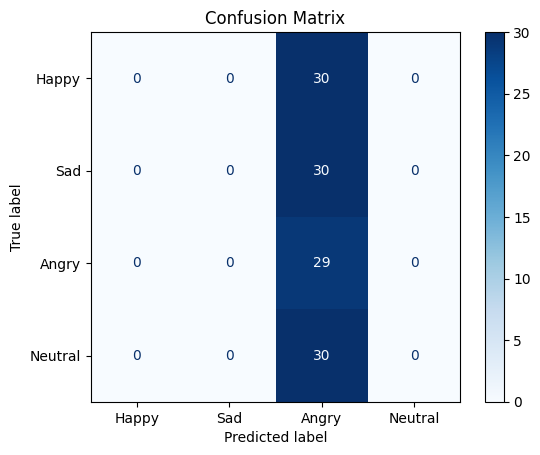

In [27]:
cm = confusion_matrix(test_features_arrays_labels, test_predicted_labels, labels=kmeans.clusters_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=kmeans.clusters_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## **model 2**


### Accuracy vs iterations (model 2)


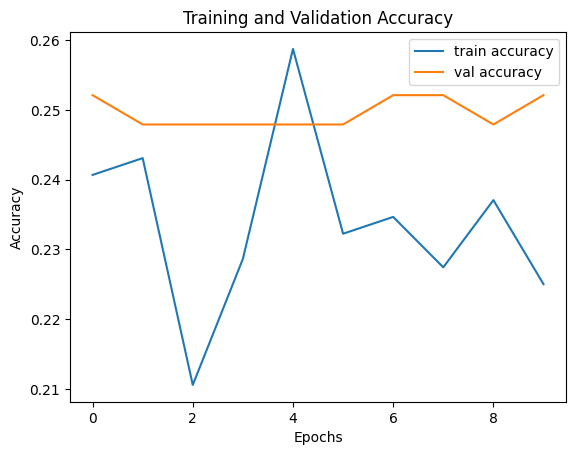

In [28]:
plt.plot(model2_history.history['accuracy'], label='train accuracy')
plt.plot(model2_history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### K-fold cross-validation (model 2)

In [29]:
start_time = time()
kf = KFold(n_splits=CORSS_VALIDATIOLN_ITERATIONS, shuffle=True, random_state=RANDOM_SEED)

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
    print(f"\nStarting fold {fold + 1}/{CORSS_VALIDATIOLN_ITERATIONS}...")
    
    fold_train_data = df.iloc[train_idx]
    fold_val_data = df.iloc[val_idx]
    
    fold_train_gen = train_datagen.flow_from_dataframe(
        dataframe=fold_train_data,
        x_col='img_path',
        y_col='label',
        target_size=TAREGT_SIZE_TUPLE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    fold_val_gen = val_datagen.flow_from_dataframe(
        dataframe=fold_val_data,
        x_col='img_path',
        y_col='label',
        target_size=TAREGT_SIZE_TUPLE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    fold_model = create_model2()
    
    fold_model.fit(
        fold_train_gen,
        validation_data=fold_val_gen,
        callbacks=[early_stoping, learning_rate_reduction],
        epochs=EPOCHS,
    )
    
    fold_val_accuracy = fold_model.evaluate(fold_val_gen)[1]
    print(f"\nFold {fold + 1} - Validation Accuracy: {fold_val_accuracy:.4f}")
    fold_accuracies.append(fold_val_accuracy)


average_accuracy = sum(fold_accuracies) / len(fold_accuracies)
formatted_accuracies = [f"{acc:.2f}" for acc in fold_accuracies]
print(f"All folds validation accuracies: {formatted_accuracies}")
print(f"Average Accuracy: {average_accuracy:.2f}")


calculate_and_print_time(start_time, "Model 2 K-fold cross-validation")




Starting fold 1/4...
Found 891 validated image filenames belonging to 4 classes.
Found 297 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/56 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step - accuracy: 0.2375 - loss: 1.4723

2025-05-01 13:27:27.472754: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,32,510,510]{3,2,1,0}, f32[11,32,508,508]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-01 13:27:27.556083: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.083510238s
Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[11,32,510,510]{3,2,1,0}, f32[11,32,508,508]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","c

56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2374 - loss: 1.4695 - val_accuracy: 0.2290 - val_loss: 1.3949 - learning_rate: 0.0010
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 925ms/step - accuracy: 0.2527 - loss: 1.3910 - val_accuracy: 0.2492 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 903ms/step - accuracy: 0.2377 - loss: 1.3908 - val_accuracy: 0.2492 - val_loss: 1.3939 - learning_rate: 0.0010
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.0486 - loss: 1.4720

Fold 1 - Validation Accuracy: 0.2290

Starting fold 2/4...
Found 891 validated image filenames belonging to 4 classes.
Found 297 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 934ms/step - accuracy: 0.2728 - loss: 1.4140 - val_accuracy: 0.2323 - val_loss: 1.4282 - learning_rate: 0.0010
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 899ms/step - accuracy: 0.2605 - loss: 1.3919 - val_accuracy: 0.2862 - val_loss: 1.3822 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 897ms/step - accuracy: 0.2493 - loss: 1.3935 - val_accuracy: 0.2559 - val_loss: 1.3987 - learning_rate: 0.0010
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.2456 - loss: 1.4067
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 899ms/step - accuracy: 0.2456 - loss: 1.4067 - val_accuracy: 0.2559 - val_loss: 1.3913 - learning_rate: 0.0010
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 913ms/step - accuracy: 0.2328 - loss: 1.3912 - val_accuracy: 0.2256 - val_loss: 1.3915 - learning_rate: 5.0000e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.2782 - loss: 1.3625

Fold 2 - Valida

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 67s 921ms/step - accuracy: 0.2592 - loss: 1.4170 - val_accuracy: 0.2660 - val_loss: 1.3860 - learning_rate: 0.0010
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 926ms/step - accuracy: 0.2550 - loss: 1.3908 - val_accuracy: 0.2391 - val_loss: 1.3912 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.2763 - loss: 1.3876
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 908ms/step - accuracy: 0.2760 - loss: 1.3877 - val_accuracy: 0.2660 - val_loss: 1.3906 - learning_rate: 0.0010
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.5751 - loss: 1.3617

Fold 3 - Validation Accuracy: 0.2660

Starting fold 4/4...
Found 891 validated image filenames belonging to 4 classes.
Found 297 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 936ms/step - accuracy: 0.2495 - loss: 1.4778 - val_accuracy: 0.2054 - val_loss: 1.3931 - learning_rate: 0.0010
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 903ms/step - accuracy: 0.2326 - loss: 1.3953 - val_accuracy: 0.2290 - val_loss: 1.4038 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 903ms/step - accuracy: 0.2372 - loss: 1.3903 - val_accuracy: 0.2559 - val_loss: 1.4263 - learning_rate: 0.0010
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.2339 - loss: 1.3715

Fold 4 - Validation Accuracy: 0.2054
All folds validation accuracies: ['0.23', '0.29', '0.27', '0.21']
Average Accuracy: 0.25

Model 2 K-fold cross-validation Done in : 0 h, 14 m, 54 s


###  Confusion matrix (model 2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step


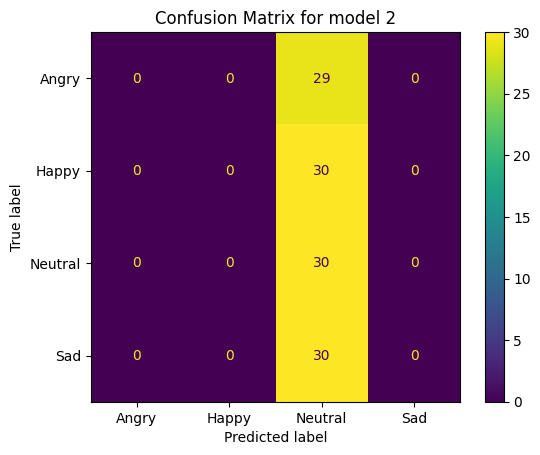

In [30]:
y_true = test_gen.classes
y_pred = model2.predict(test_gen)
y_pred_classes = y_pred.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
disp.plot(cmap='viridis')
plt.title("Confusion Matrix for model 2")
plt.show()

### Print whole notebook run time

In [31]:
calculate_and_print_time(global_start_time, f"All notebook on {get_hardware_name()}")


All notebook on GPU Done in : 2 h, 6 m, 31 s
